### The main aim of the project is to examine different approaches for training a model that classifies clouds in the satelite pictures.

In [ ]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
import os
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [10]:
DATASET_DIRECTORY = './data'
TEST_DATASET_DIRECTORY = './test_data'
IMG_PER_REG = 5
PIX_PER_IMG = 509**2

def read_image_patch_file(path):
    path = path
    with rasterio.open(path) as image:
        image_array = image.read()
    return image_array

def read_image_data(path):
    # Load features
    features = read_image_patch_file(os.path.join(path, 'S2L1C.tif'))
    features2 = read_image_patch_file(os.path.join(path, 'S2L2A.tif'))
    features3 = read_image_patch_file(os.path.join(path, 'S1.tif'))
    # Join features
    features = np.concatenate((features, features2, features3), axis=0)
    # Load labels
    labels = read_image_patch_file(os.path.join(path, 'labels/manual_hq.tif'))
    return features, labels

def load_all_images(dir):
    images = []
    labels = []
    list_regions = []
    
    for archive in os.listdir(dir):
        for region in os.listdir(dir + '/' + archive):
            list_regions.append(region)
            for image in os.listdir(dir + '/' + archive + '/' + region):
                features, label = read_image_data(os.path.join(dir, archive, region, image))
                images.append(features)
                labels.append(label) 

    images = np.array(images)
    labels = np.array(labels)
    images = np.moveaxis(images, 1, 3)
    
    images = images.reshape(-1, images.shape[-1])
    df = pd.DataFrame(images)
    labels = labels.reshape(-1, 1)
    df['label'] = labels

    # Change column types to int
    df = df.astype(int)

    # Reindexing the dataframe with ROIs and pixels
    region = []
    for roi in list_regions:
        region = region + [roi] * IMG_PER_REG * PIX_PER_IMG

    image = []
    for i in range(1, IMG_PER_REG + 1):
        image = image + [i] * PIX_PER_IMG

    image = image * len(list_regions)

    pixel = list(range(1, PIX_PER_IMG + 1)) * IMG_PER_REG * len(list_regions)

    multi_index = pd.MultiIndex.from_tuples(list(zip(region, image, pixel)), names=["region", "image", "pixel"])
    df.set_index(multi_index, inplace=True)
    
    S2L2A_names = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12", "AOT", "WVP", "TCI_R", "TCI_G", "TCI_B"]
    S2L2A_names = ("S2L2A_" + pd.Series(S2L2A_names)).tolist()
    S2L1C_names = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B10", "B11", "B12"]
    S2L1C_names = ("S2L1C_" + pd.Series(S2L1C_names)).tolist()
    S1C_names = ["VV", "VH", "angle"]
    S1C_names = ("S1C_" + pd.Series(S1C_names)).tolist()

    col = S2L2A_names + S2L1C_names + S1C_names + ["label"]
    col = dict(zip(range(0, len(col)+1), col))

    df.rename(columns = dict(col), inplace = True)

    print("Loaded " + str(len(list_regions)) + " Regions Of Interest.")
    return df

In [8]:
df = load_all_images(DATASET_DIRECTORY)
df

NameError: name 'os' is not defined

In [5]:
def sample_data(df, p_pixels):
    """
    Sample data from the dataframe.
    
    Args:
        df (pd.DataFrame): Dataframe with the data.
        n_images (int): Number of images from ROI to sample.
        p_pixels (float): Percentage of pixels from image to sample.
    """
    regions = df.index.levels[0]
    images = df.index.levels[1]
    pixels = pd.Series(df.index.levels[2]).sample(int(p_pixels*509**2))
    print(f"Sampling {int(p_pixels*509**2)} pixels from {len(images)} images from {len(regions)} regions.")
    df_sample = df.loc[regions, images, pixels]
    return df_sample

In [6]:
sampled_data = sample_data(df, 0.001)
sampled_data.shape

NameError: name 'df' is not defined

# EDA

In [3]:
def plot_cloudiness(df, region_name, images = [1, 2, 3, 4, 5], kind="pie"):
    """Plots the cloudiness (cloud percentage) of a given region name (str), list of regions (list) or all of the regions (then type 'all' in the region_name).
    Then, it's possible to select which images should be considered by typing an integer from [1,2,3,4,5] or a list of integers.
    The parameter kind decides which kind of plot will be displayed ('bar', 'barh', 'pie')
    The function returns a Series with the percentage of each label in the decimal form 0.sth"""
    
    # Selecting appropriate data
    if(region_name == "all"):
        df_plot = df['label'].droplevel(0)
    elif(type(region_name) == list):
        df_plot = df['label'].loc[region_name].droplevel(0)
    else:
        df_plot = df['label'].loc[region_name]
    
    if images != [1, 2, 3, 4, 5]:
        df_plot = df_plot.loc[images]
    # Now we don't have to drop the index level because the function value_counts doesn't take an index form into account
    norm_values = df_plot.value_counts(normalize=True)

    # Setting labels
    norm_values.index = norm_values.index.map({0: "Clear", 1: "Thick Cloud", 2: "Thin Cloud", 3: "Cloud Shadow"})

    # Handling colors and title
    colors = norm_values.index.map({"Clear": "olivedrab", "Thick Cloud": "whitesmoke", "Thin Cloud": "darkseagreen", "Cloud Shadow": "dimgray"})
    
    if(region_name == "all"):
        plot_title = "Cloud percentage of all regions"
    elif(type(region_name) == list):
        plot_title = "Cloud percentage of the selected regions"
    else:
        plot_title = "Cloud percantage of the " + region_name
    
    if(images == [1,2,3,4,5]):
        plot_title = plot_title + " among all images"
    else:
        plot_title = plot_title + " among images: " + str(images).strip('[]')

    
    if(kind == "pie"):
        plt.pie(norm_values * 100, autopct='%1.1f%%', startangle=90, colors = colors, labels = norm_values.index);
        plt.title(plot_title)
        plt.show()
    
    elif(kind == "barh"):
        ax = (norm_values * 100).plot.barh(xlim = [0,100], xlabel = "Percentage", ylabel = "", title = plot_title,
                                           color = colors, edgecolor = "black", linewidth = 0.5)
        ax.bar_label(ax.containers[0], fmt='%1.1f%%', padding = 2)
        ax.invert_yaxis()

    elif(kind == "bar"):
        ax = (norm_values * 100).plot.bar(xlabel = "", ylim = [0,100], ylabel = "Percentage", title = plot_title,
                                          color = colors, edgecolor = "black", linewidth = 0.5)
        ax.bar_label(ax.containers[0], fmt='%1.1f%%')
        
    return norm_values

In [4]:
print(plot_cloudiness(sampled_data, "ROI_0001", image=2, kind = "pie"))

NameError: name 'sampled_data' is not defined

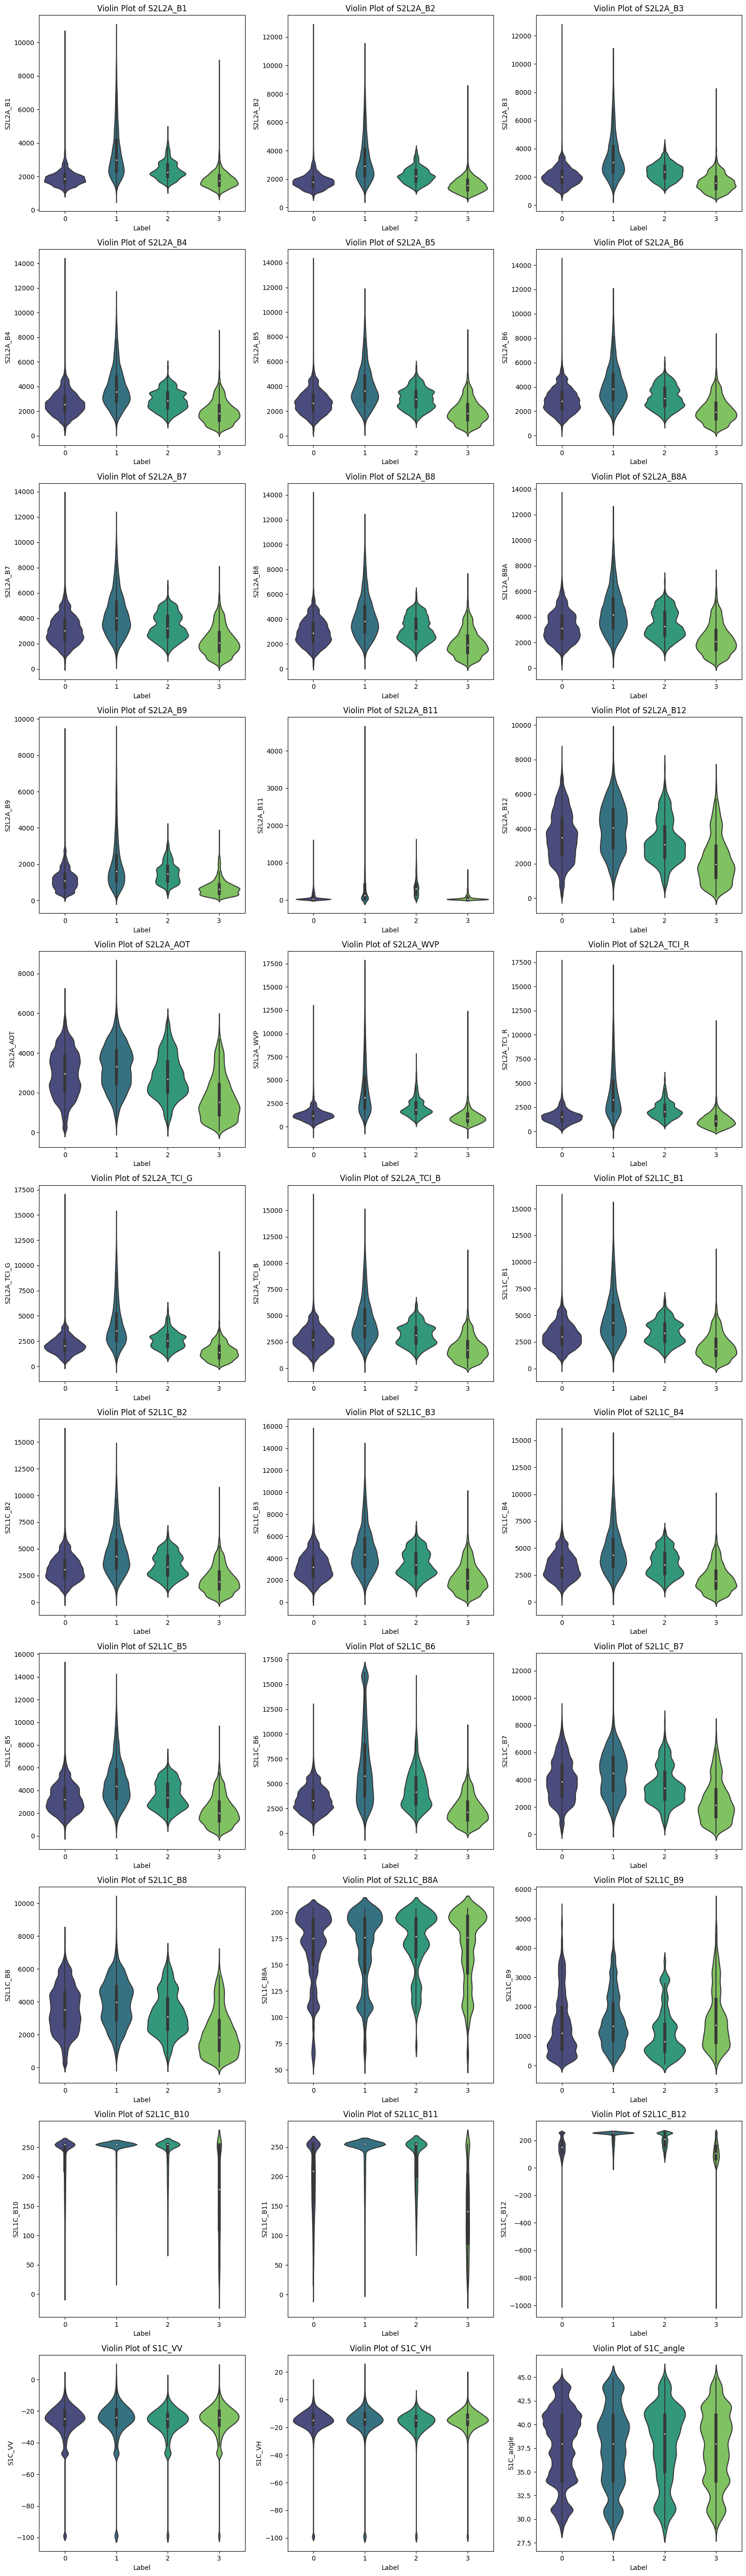

In [56]:
## We begin the Exploratory Data Analysis by showing a violin plot of each feature so will get a basic insight into the data distribution
import seaborn as sns

features = sampled_data.drop('label', axis=1)

num_features = len(features.columns)
num_rows = (num_features // 3) + (num_features % 3)
num_cols = 3

plt.figure(figsize=(16, 5 * num_rows))
for i, feature in enumerate(features.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.violinplot(x=sampled_data['label'], y=features[feature], palette='viridis')
    plt.title(f'Violin Plot of {feature}')
    plt.xlabel('Label')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

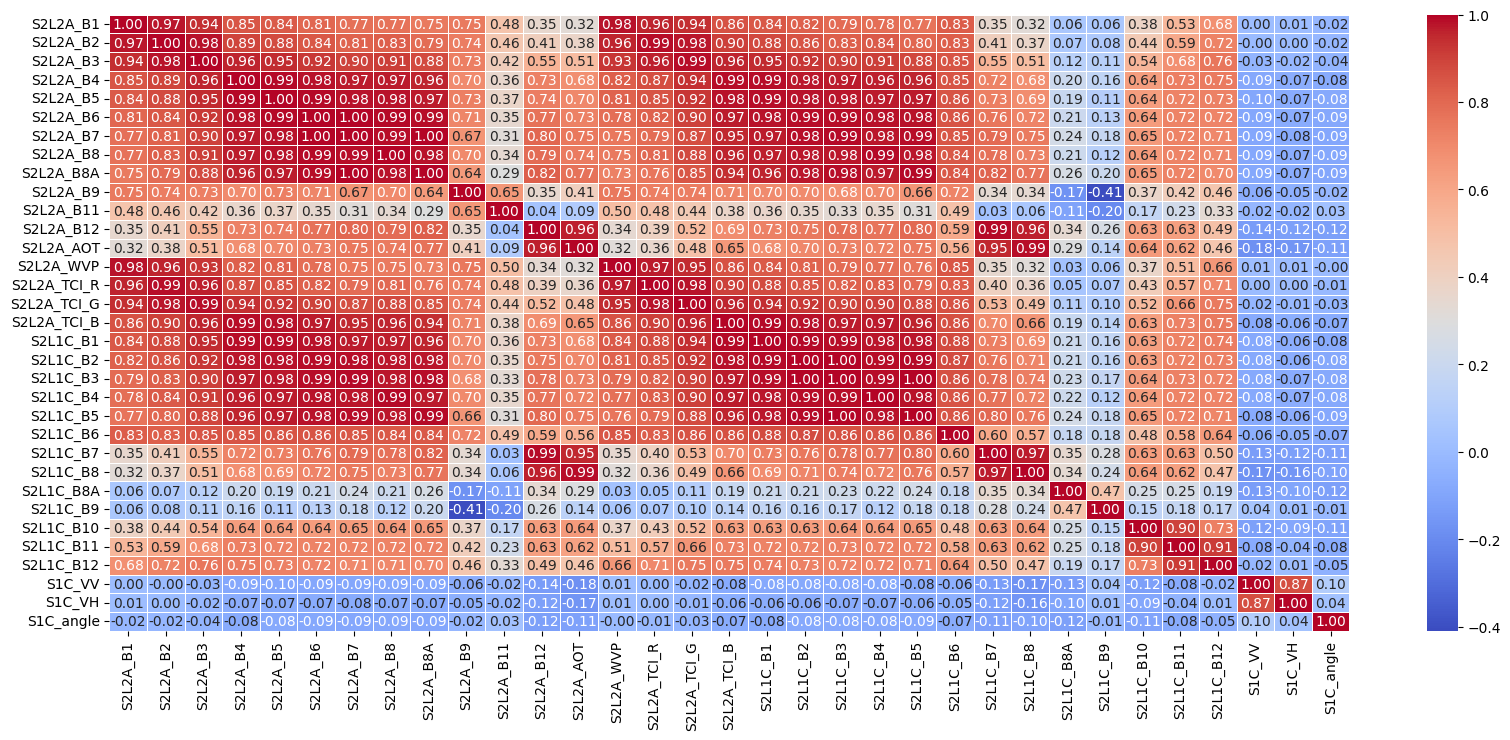

In [58]:
# Visualizing the correlation matrix between the features
features = sampled_data.drop('label', axis=1)

plt.figure(figsize=(20, 8))
sns.heatmap(features.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

In [ ]:
## We can see that the most correlated features are the first bands from both S2L2A, S2L1C and bands from 4 to 8A from S2L2A
## Therefore we can try to reduce the dimensinality of the data using PCA

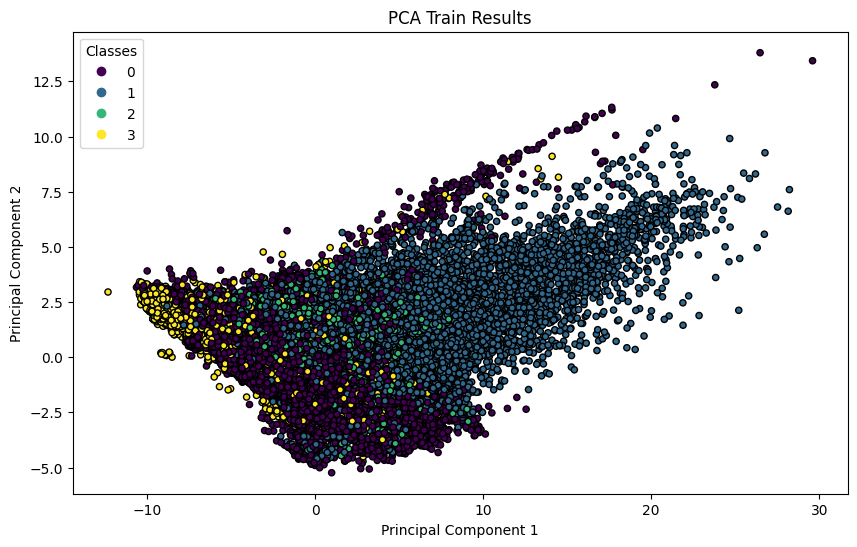

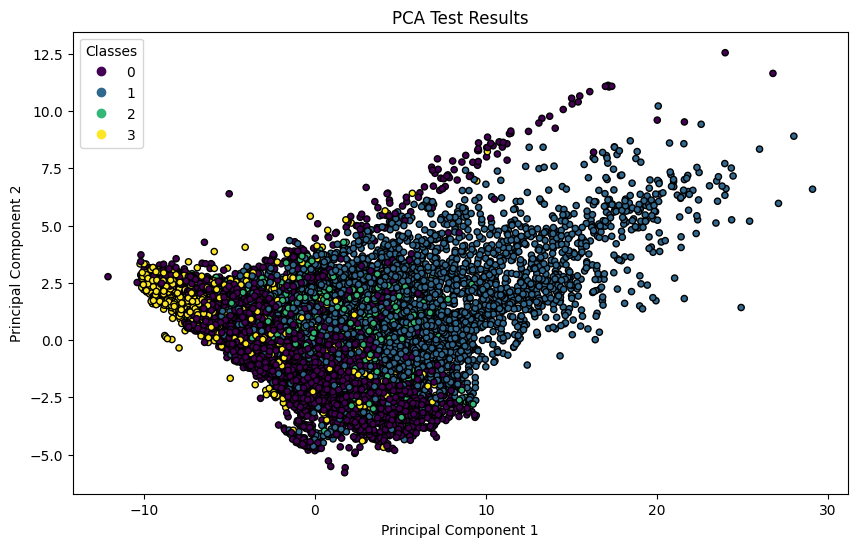

In [64]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

features = sampled_data.drop('label', axis=1)

features_train, features_test, y_train, y_test = train_test_split(features, sampled_data['label'], test_size=0.3, random_state=1)
scaler = StandardScaler()
scaled_features_train = scaler.fit_transform(features_train)
scaled_features_test = scaler.transform(features_test)

pca = PCA(n_components = 2)
pca_trained = pca.fit_transform(scaled_features_train)
pca_test = pca.transform(scaled_features_test)


# Now we will display results of the training of PCA
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_trained[:, 0], pca_trained[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=20)
plt.title('PCA Train Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title='Classes')
plt.show()


# And of the PCA on the test data
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_test[:, 0], pca_test[:, 1], c=y_test, cmap='viridis', edgecolor='k', s=20)
plt.title('PCA Test Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title='Classes')
plt.show()

In [14]:
# Change label to binary
sampled_data.loc[:, 'label'] = sampled_data.loc[:, 'label'] > 0

# Change label dtype to int
sampled_data = sampled_data.astype(int)
sampled_data

0     1     2     3     4     5     6     7     8  \
region   image pixel                                                          
ROI_0001 1     162468  1729  1577  1578  1777  1926  2081  2181  2166  2312   
               74978   1652  1551  1543  1759  1833  1990  2094  2091  2198   
               91840   1503  1199  1112  1264  1528  1723  1758  1615  1862   
               189442  1664  1551  1521  1724  1796  1930  2031  2026  2134   
               116381  1632  1468  1440  1595  1667  1797  1956  1943  2061   
...                     ...   ...   ...   ...   ...   ...   ...   ...   ...   
ROI_0069 5     7910    2449  2294  2198  2336  2237  2292  2397  2189  2432   
               142870  1990  1799  1685  1747  1673  1720  1798  1722  1823   
               208280  4305  4241  4158  4510  4397  4521  4760  4433  4936   
               197424  1906  1580  1395  1371  1374  1412  1464  1272  1465   
               247163  3314  3285  3161  3382  3348  3510  3680  3416  3835   

                          9  ...    24   25    26   27   28   29  30  31  32  \
region   image pixel         ...                                               
ROI_0001 1     162468  1185  ...  2617  190   696  187  158  120 -21 -13  31   
               74978   1094  ...  2371  190   696  181  148  113 -21 -15  31   
               91840    944  ...  2259  190   544  114   80   53 -21 -11  31   
               189442  1118  ...  2322  190   696  180  149  116 -26 -12  31   
               116381  1071  ...  2294  191   696  159  134   99 -16 -13  31   
...                     ...  ...   ...  ...   ...  ...  ...  ...  ..  ..  ..   
ROI_0069 5     7910     502  ...  2559  188  2151  255  241  217 -13 -12  30   
               142870   461  ...  2790  179  1801  231  213  182 -16 -10  30   
               208280  1093  ...  4321  189  1494  255  255  255 -22 -17  30   
               197424   368  ...  2476  181  1866  197  185  162 -11   0  30   
               247163   799  ...  3519  190  1494  255  255  255 -13   0  30   

                       label  
region   image pixel          
ROI_0001 1     162468      1  
               74978       0  
               91840       0  
               189442      1  
               116381      1  
...                      ...  
ROI_0069 5     7910        1  
               142870      0  
               208280      1  
               197424      0  
               247163      1  

[77700 rows x 34 columns]

# Logistic Regression

In [21]:
pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', RidgeClassifier())])

parameters = {
    'classifier__alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(sampled_data.drop('label', axis=1), sampled_data['label'])

print(f'Accuracy: {grid_search.best_score_:.3}')
print(f'Best parameters: {grid_search.best_params_}')

Accuracy: 0.79
Best parameters: {'classifier__alpha': 0.1}


# KNN

In [17]:
pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', KNeighborsClassifier())])

parameters = {
    'classifier__n_neighbors': list(range(1, df.shape[1] - 1, 2)),
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(sampled_data.drop('label', axis=1), sampled_data['label'])

print(f'Accuracy: {grid_search.best_score_:.3}')
print(f'Best parameters: {grid_search.best_params_}')

Accuracy: 0.719
Best parameters: {'classifier__n_neighbors': 31}


# Random Forest

In [20]:
pipeline = Pipeline([('classifier', RandomForestClassifier())])

parameters = {
    'classifier__n_estimators': [1000],
    # 'classifier__max_depth': list(range(1, 10)),
    'classifier__max_depth': list(range(6, 7)),
    'classifier__min_samples_split': list(range(2, 3)),
    # 'classifier__min_samples_split': list(range(2, 10, 2)),
    'classifier__min_samples_leaf': list(range(3, 4,)),
    # 'classifier__min_samples_leaf': list(range(1, 10, 2)),
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(sampled_data.drop('label', axis=1), sampled_data['label'])

print(f'Accuracy: {grid_search.best_score_:.3}')
print(f'Best parameters: {grid_search.best_params_}')

Accuracy: 0.769
Best parameters: {'classifier__max_depth': 6, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 1000}


In [22]:
final_model = grid_search.best_estimator_

# Load and process test data

In [23]:
df_test = load_all_images(TEST_DATASET_DIRECTORY)
df_test['label'] = df_test['label'] > 0
df_test = df_test.astype(int)
df_test

Loaded 20 Regions Of Interest.


0     1     2     3     4     5     6     7     8  \
region   image pixel                                                          
ROI_9771 1     1       1164   876   740   693  1032  1523  1777  1970  2069   
               2       1176   895   745   727  1074  1557  1833  1902  2110   
               3       1176   904   736   709  1074  1557  1833  1798  2110   
               4       1176   886   722   684  1137  1673  1949  1885  2246   
               5       1176   891   738   727  1137  1673  1949  1879  2246   
...                     ...   ...   ...   ...   ...   ...   ...   ...   ...   
ROI_9992 5     259077  1655  1757  1868  2046  2240  2739  2962  2885  3113   
               259078  1655  1826  1957  2152  2240  2739  2962  2953  3113   
               259079  1655  1842  1977  2134  2198  2667  2919  2874  3088   
               259080  1655  1774  1836  2025  2198  2667  2919  2815  3088   
               259081  1655  1758  1803  1882  1985  2398  2554  2696  2727   

                          9  ...    24   25   26   27   28   29  30  31  32  \
region   image pixel         ...                                              
ROI_9771 1     1       1071  ...   750  150  493   55   42   21 -14  -7  43   
               2       1137  ...   842  150  510   60   43   23 -12  -8  43   
               3       1137  ...   842  150  510   57   42   24 -12  -9  43   
               4       1137  ...   908  150  567   54   40   24 -11  -8  43   
               5       1137  ...   908  150  567   59   42   22 -12  -9  43   
...                     ...  ...   ...  ...  ...  ...  ...  ...  ..  ..  ..   
ROI_9992 5     259077  1347  ...  3093  113  958  235  215  177 -99 -99  39   
               259078  1347  ...  3093  113  958  249  228  189 -99 -99  39   
               259079  1347  ...  3057  113  958  247  232  192 -99 -99  39   
               259080  1347  ...  3057  113  958  234  212  182 -99 -99  39   
               259081  1347  ...  2741  113  813  215  208  180 -99 -99  39   

                       label  
region   image pixel          
ROI_9771 1     1           0  
               2           0  
               3           0  
               4           0  
               5           0  
...                      ...  
ROI_9992 5     259077      1  
               259078      1  
               259079      1  
               259080      1  
               259081      1  

[25908100 rows x 34 columns]

# Evaluate final model

Accuracy: 0.714


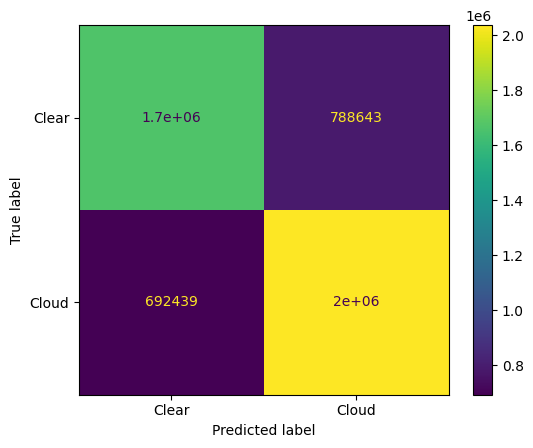

In [24]:
def evaluate_model(df, model, n_images=1):
    """
    Calculate accuracy and plot confusion matrix on test data.
    """
    if n_images > df.index.levels[0].size:
        print(f"n_images must be less than {df.index.levels[0].size}")
        return
    rois = df.index.levels[0].to_numpy()
    np.random.shuffle(rois)
    rois = rois[:n_images]
    preditions = []
    labels = []
    for roi in rois:
        image_number = np.random.randint(1, IMG_PER_REG + 1)
        pixels = df.loc[roi, image_number, :].drop('label', axis=1)
        prediction = model.predict(pixels)  
        preditions.append(prediction)
        label = df.loc[(roi, image_number), 'label']
        labels.append(label)

    predictions = np.concatenate(preditions)
    labels = np.concatenate(labels)

    cm = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Clear', 'Cloud'])
    disp.plot()

    print(f"Accuracy: {np.mean(predictions == labels):.3}")

evaluate_model(df_test, final_model, n_images=20)

              precision    recall  f1-score   support

           0       0.55      0.93      0.69     66454
           1       0.97      0.74      0.84    192627

    accuracy                           0.79    259081
   macro avg       0.76      0.83      0.77    259081
weighted avg       0.86      0.79      0.80    259081



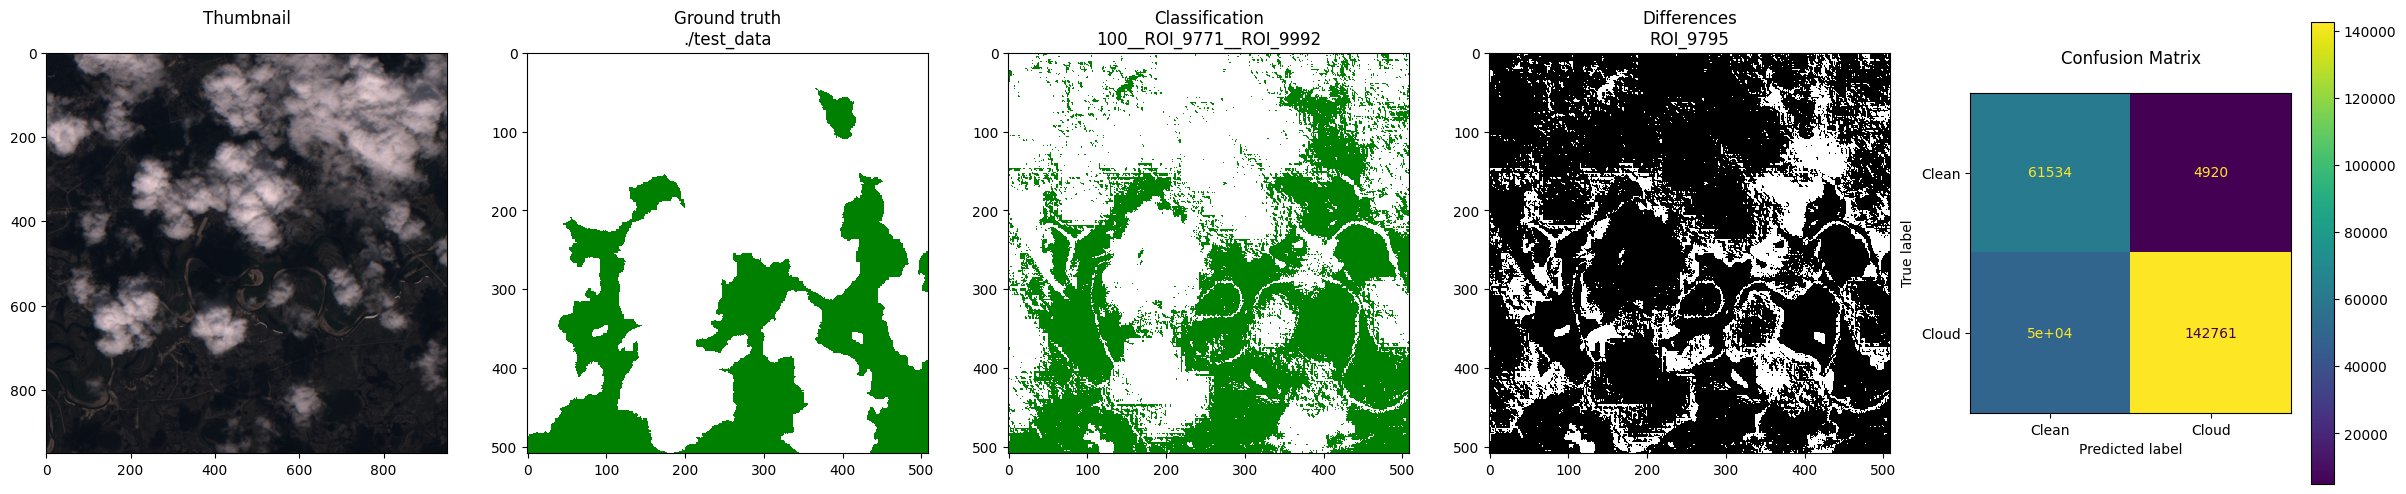

              precision    recall  f1-score   support

           0       0.83      0.66      0.73    157359
           1       0.60      0.80      0.68    101722

    accuracy                           0.71    259081
   macro avg       0.72      0.73      0.71    259081
weighted avg       0.74      0.71      0.71    259081



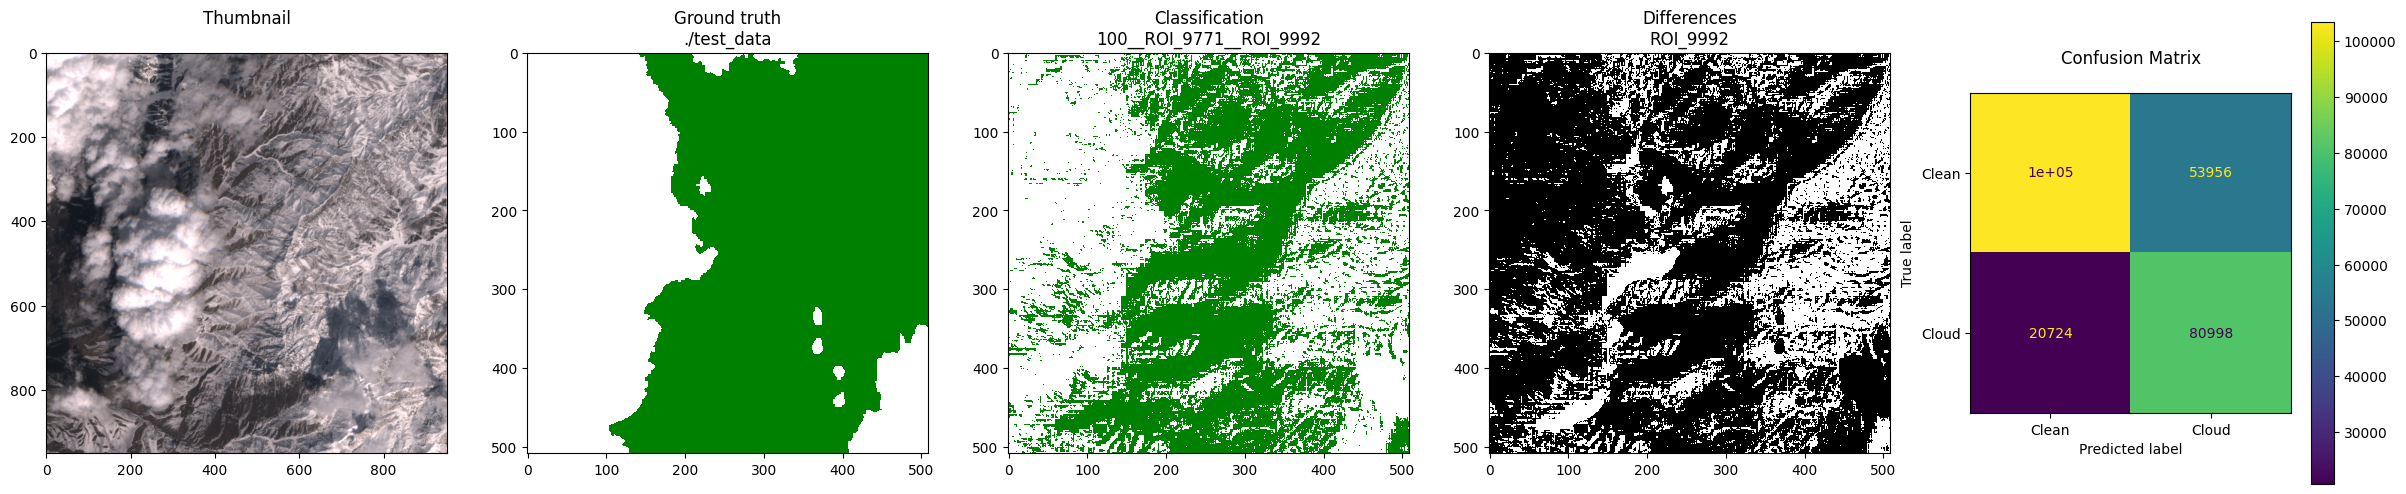

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.97      0.99    259081

    accuracy                           0.97    259081
   macro avg       0.50      0.49      0.49    259081
weighted avg       1.00      0.97      0.99    259081



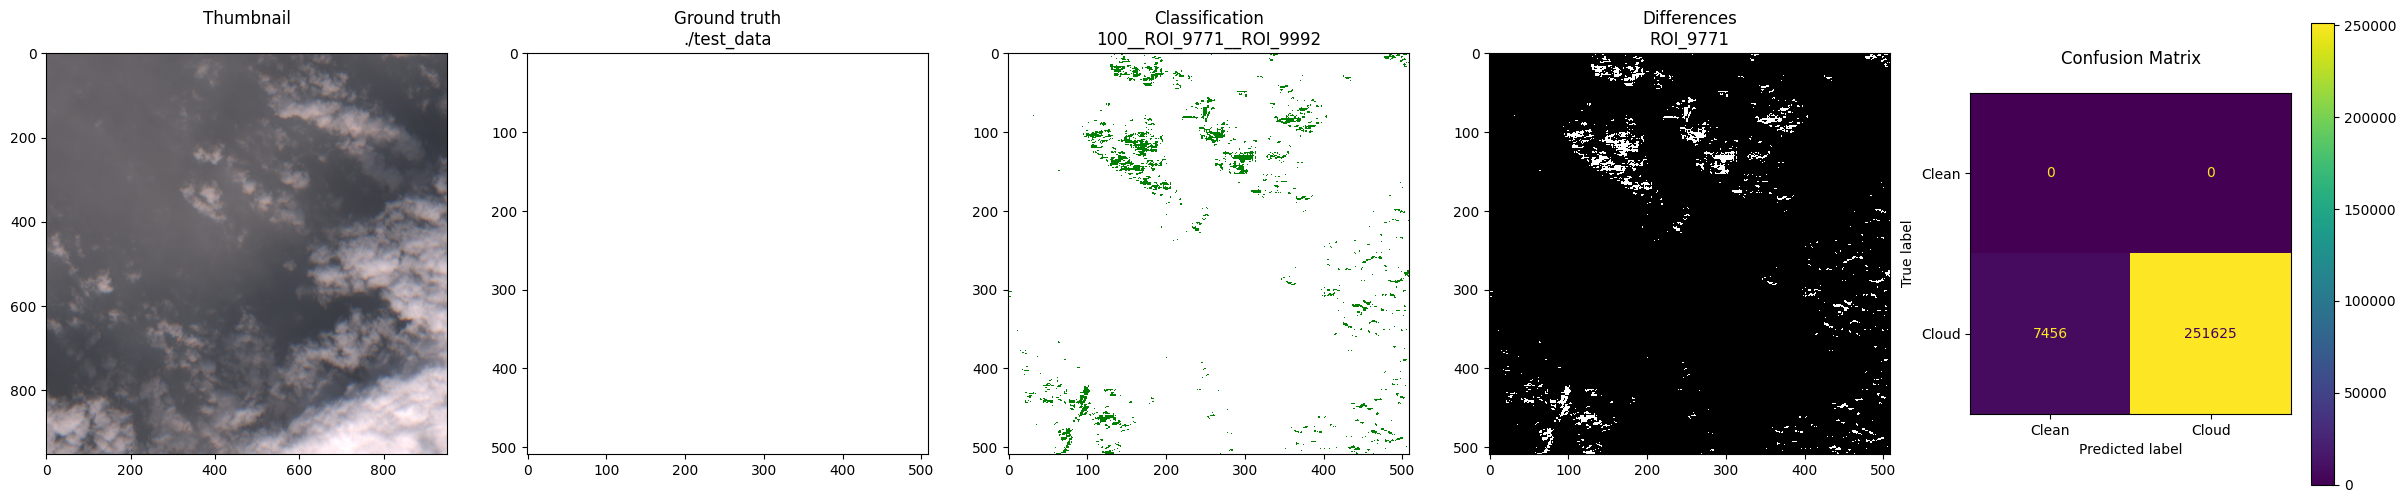

              precision    recall  f1-score   support

           0       0.92      0.92      0.92    209684
           1       0.66      0.68      0.67     49397

    accuracy                           0.87    259081
   macro avg       0.79      0.80      0.79    259081
weighted avg       0.87      0.87      0.87    259081



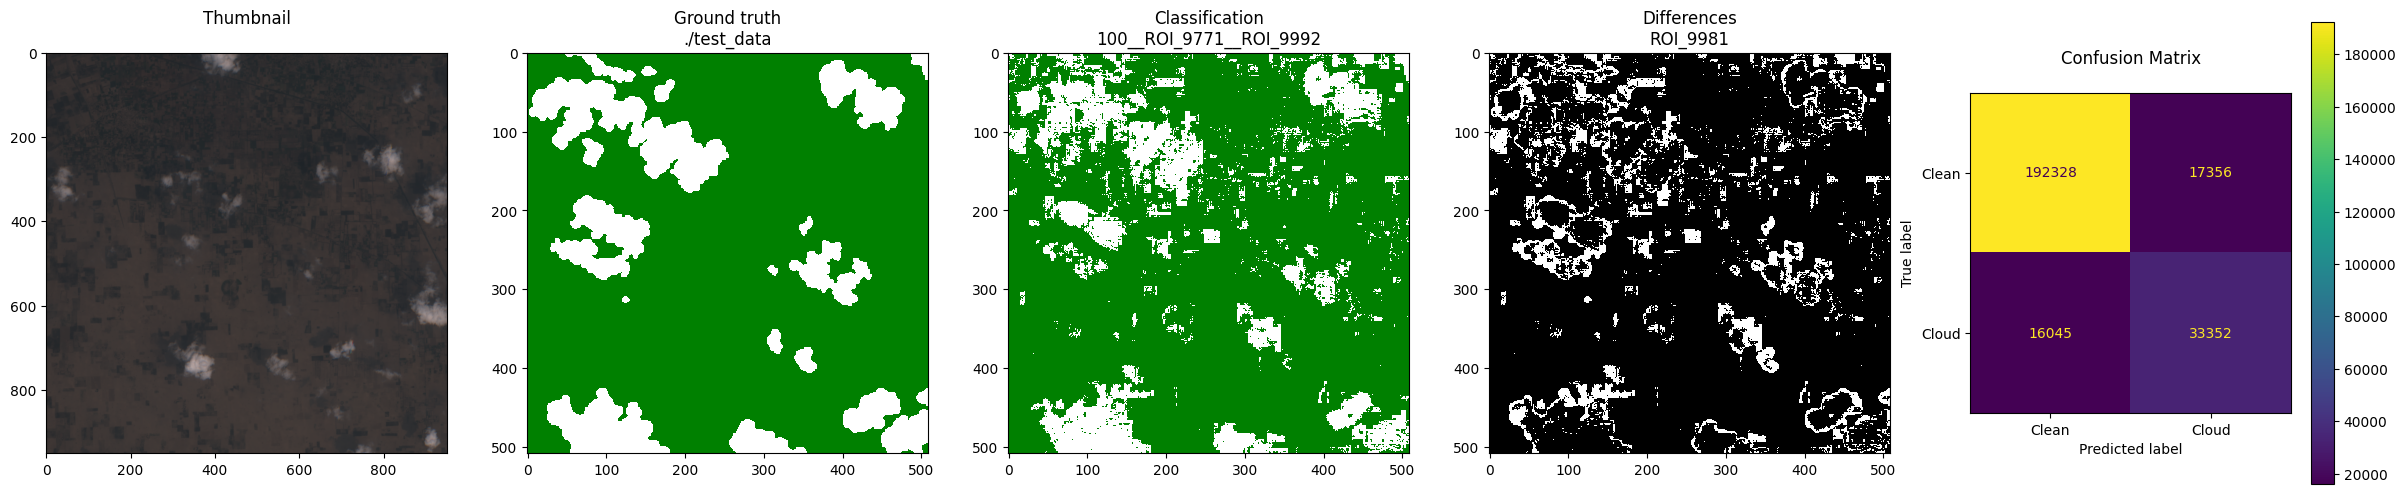

              precision    recall  f1-score   support

           0       1.00      0.59      0.74    259081
           1       0.00      0.00      0.00         0

    accuracy                           0.59    259081
   macro avg       0.50      0.30      0.37    259081
weighted avg       1.00      0.59      0.74    259081



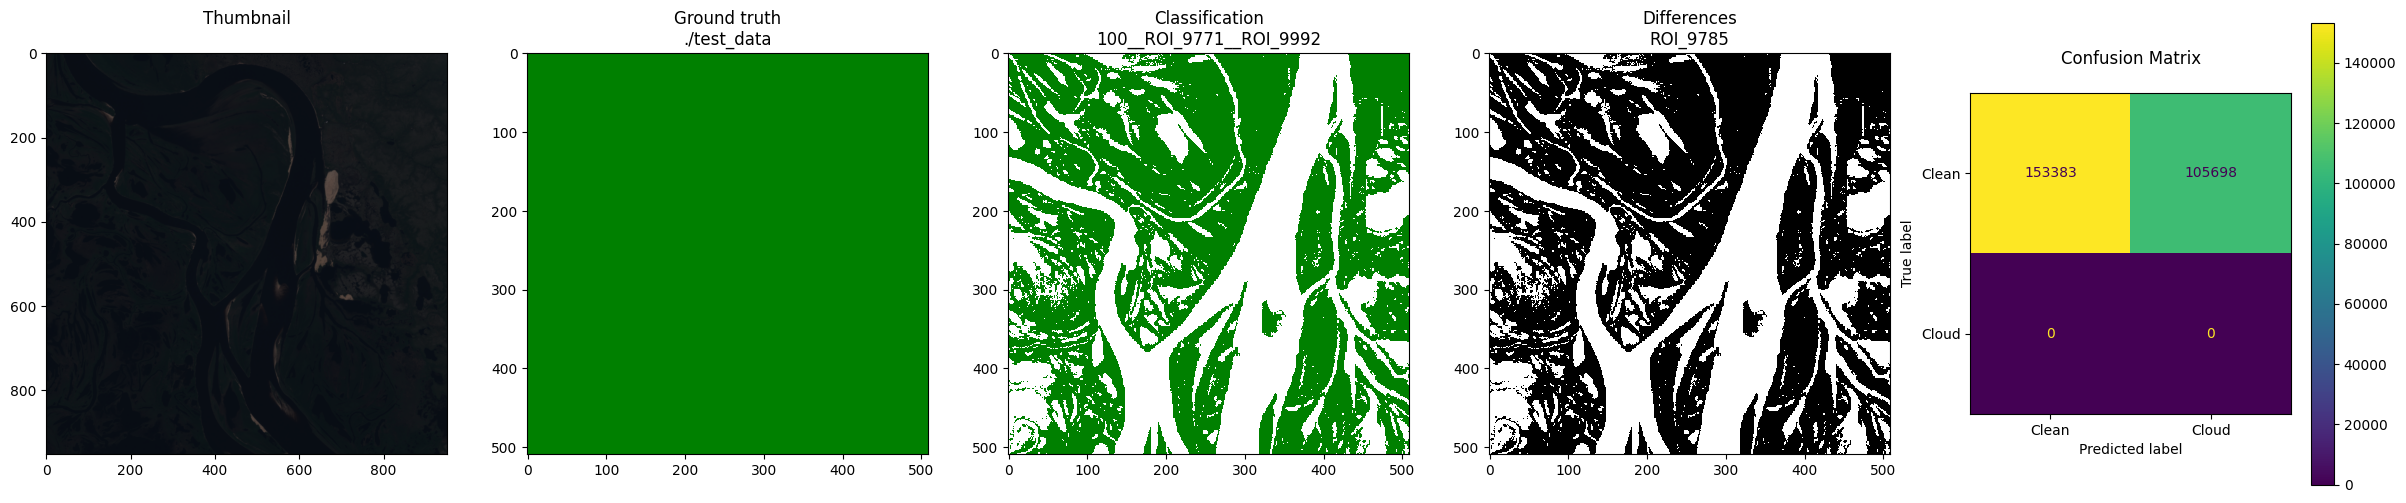

              precision    recall  f1-score   support

           0       1.00      0.88      0.94    259081
           1       0.00      0.00      0.00         0

    accuracy                           0.88    259081
   macro avg       0.50      0.44      0.47    259081
weighted avg       1.00      0.88      0.94    259081



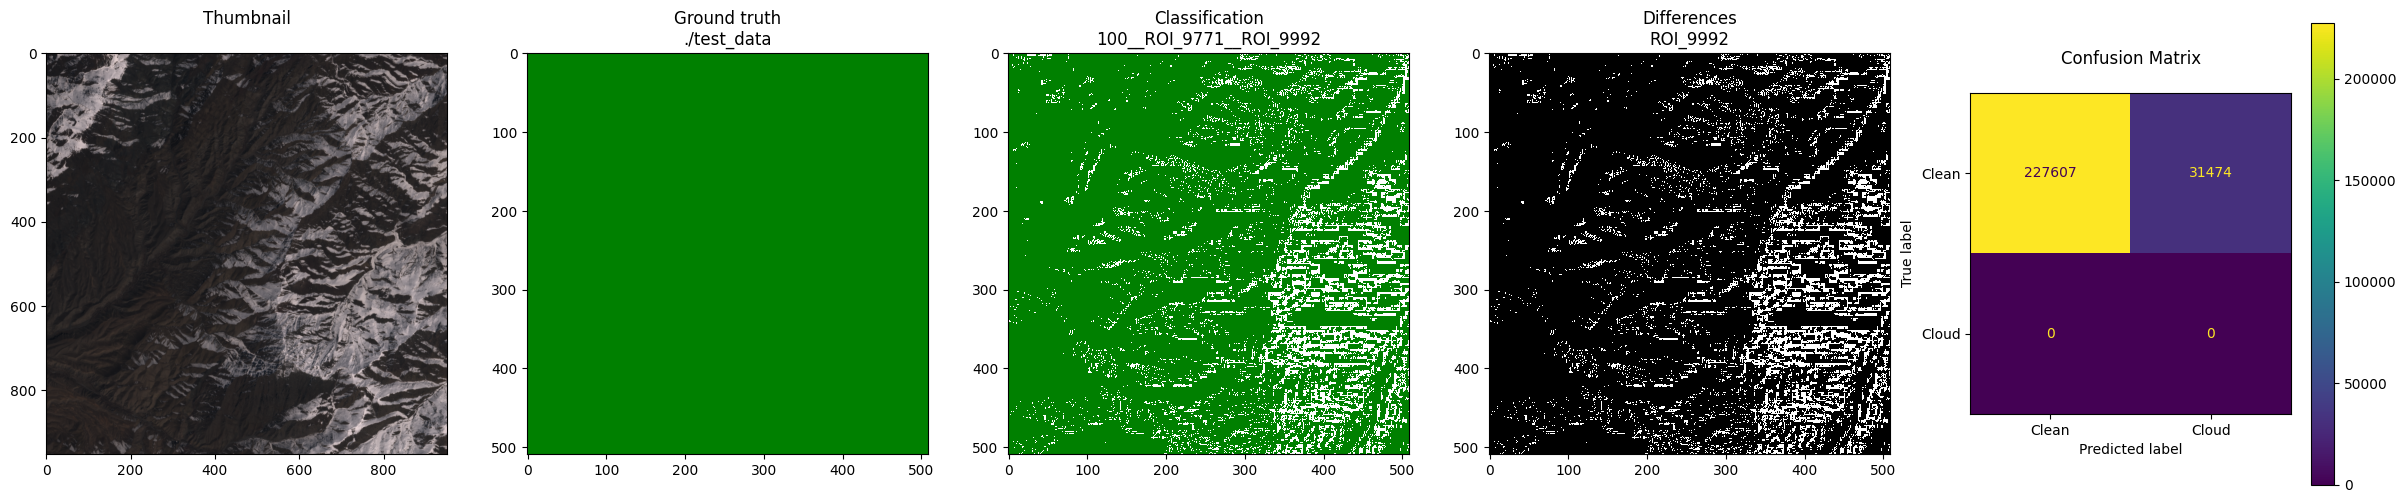

              precision    recall  f1-score   support

           0       1.00      0.97      0.98    259081
           1       0.00      0.00      0.00         0

    accuracy                           0.97    259081
   macro avg       0.50      0.48      0.49    259081
weighted avg       1.00      0.97      0.98    259081



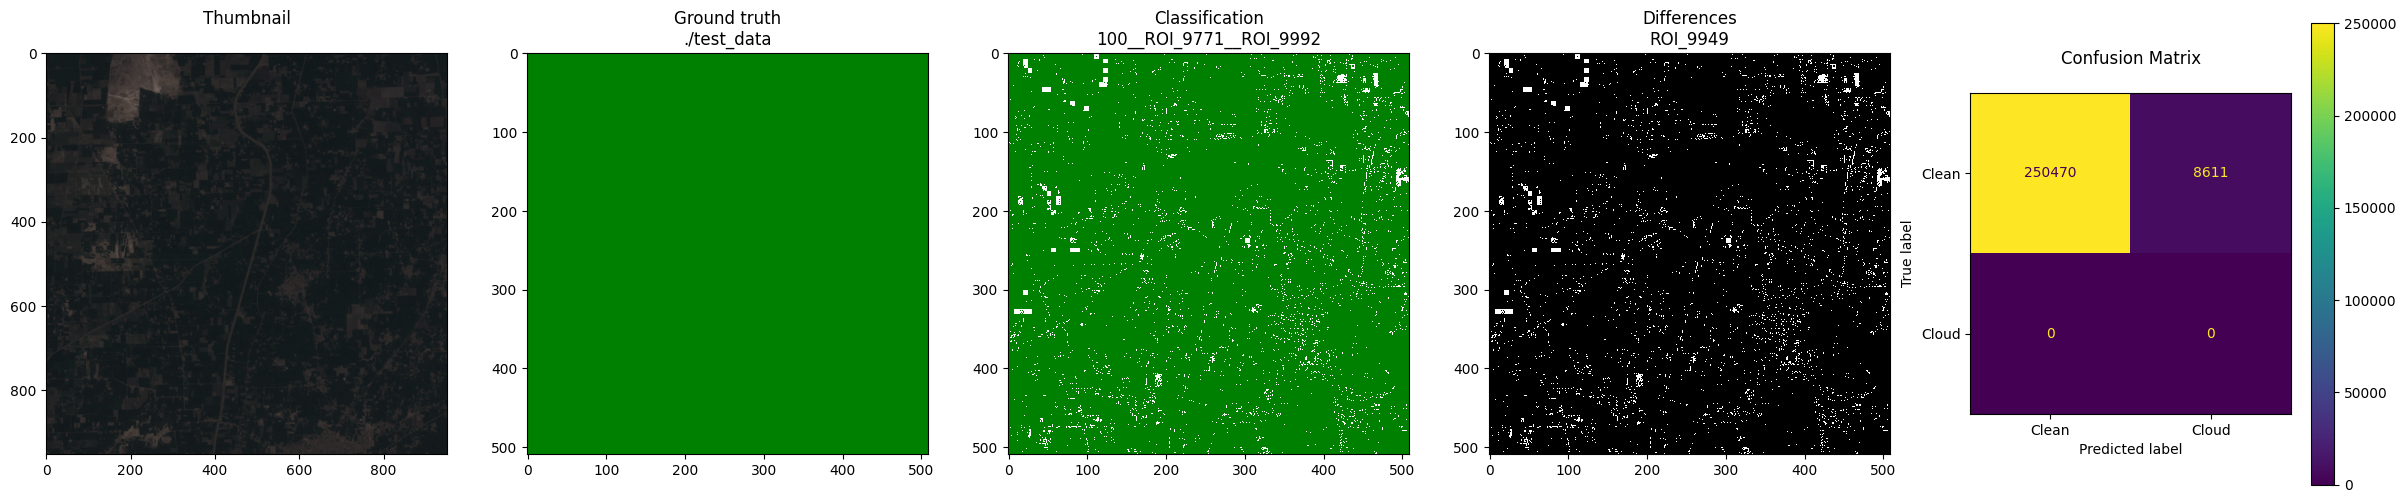

              precision    recall  f1-score   support

           0       0.99      0.71      0.83    237899
           1       0.22      0.92      0.35     21182

    accuracy                           0.73    259081
   macro avg       0.60      0.81      0.59    259081
weighted avg       0.93      0.73      0.79    259081



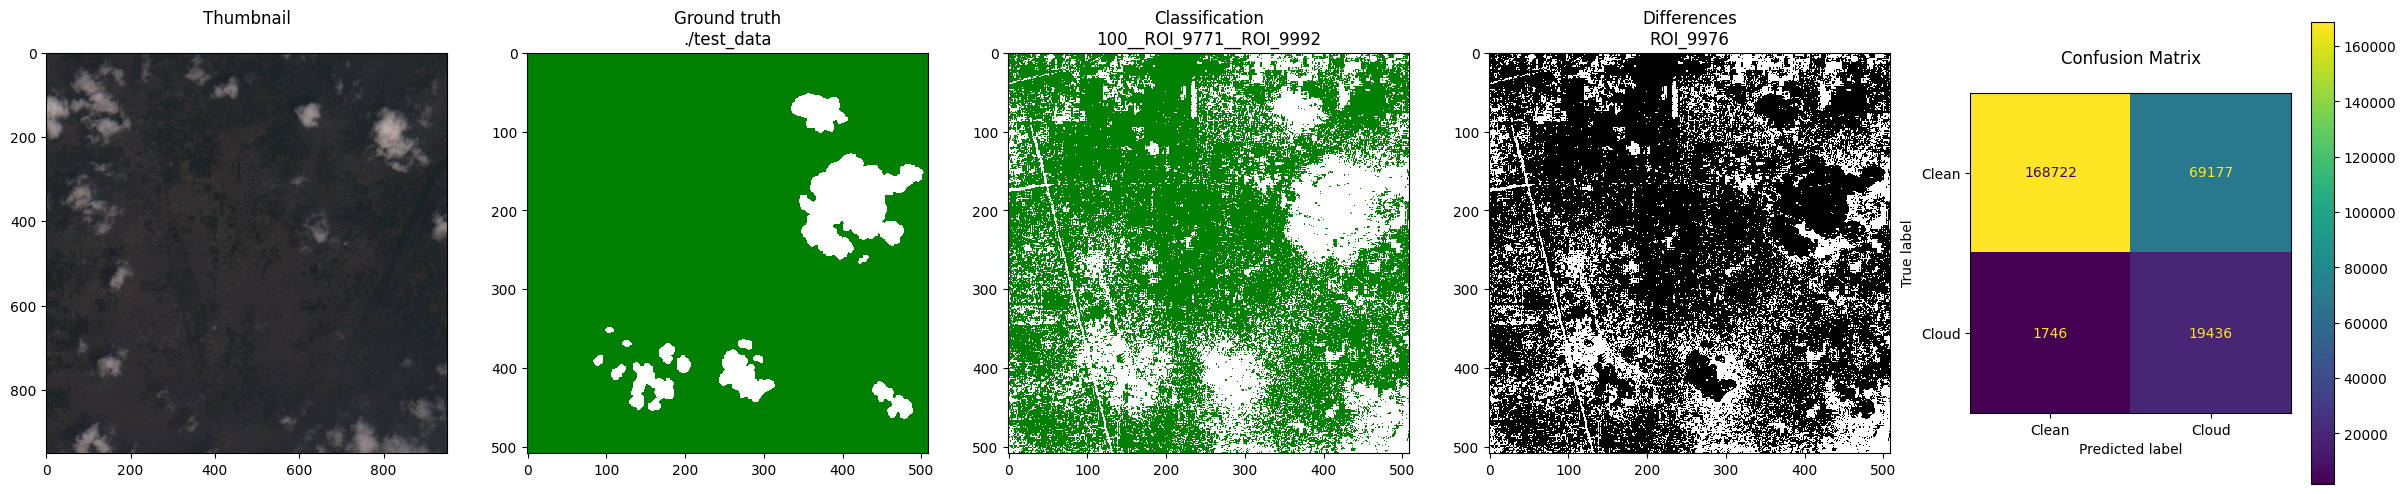

              precision    recall  f1-score   support

           0       1.00      0.06      0.12    259081
           1       0.00      0.00      0.00         0

    accuracy                           0.06    259081
   macro avg       0.50      0.03      0.06    259081
weighted avg       1.00      0.06      0.12    259081



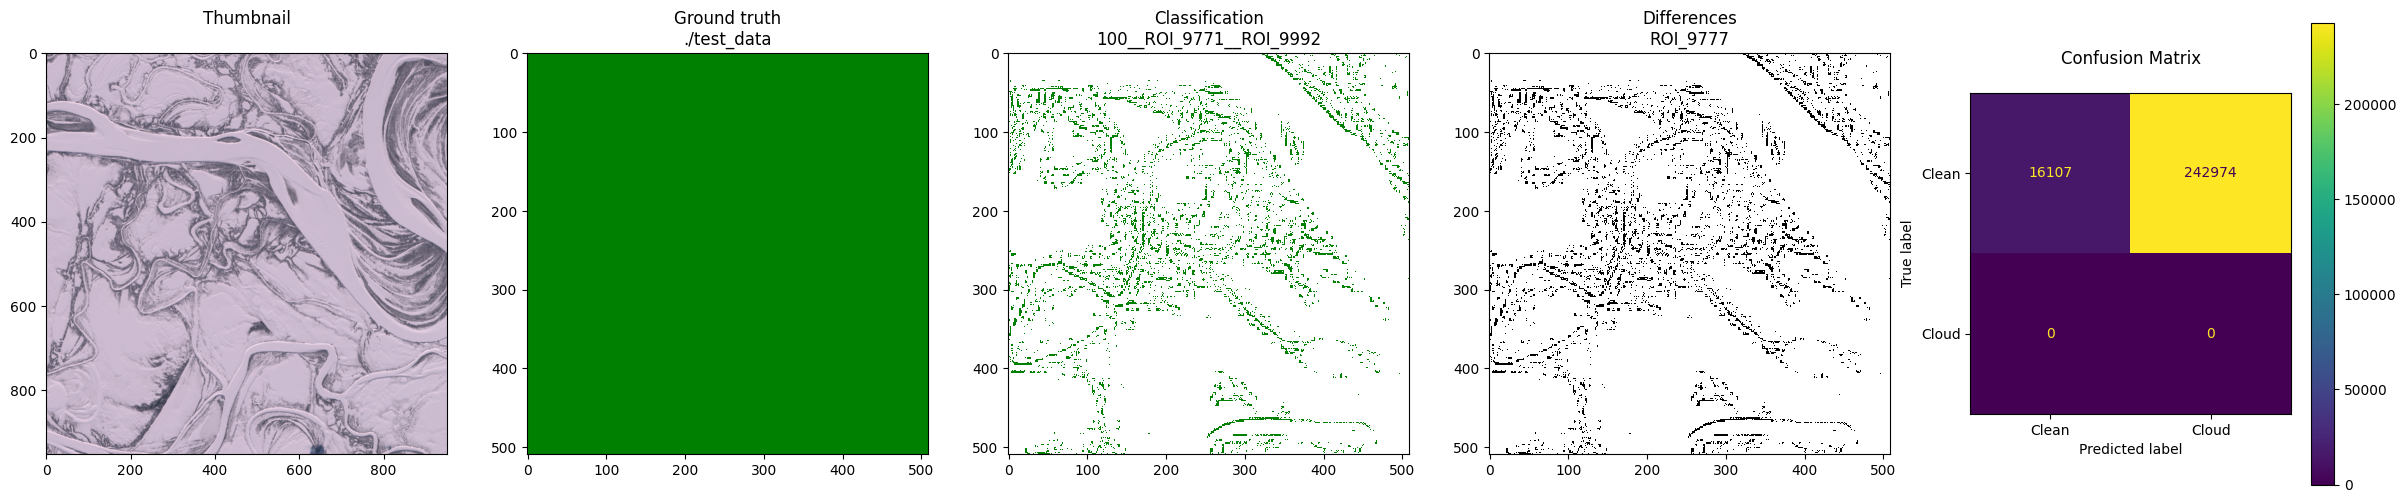

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    259081
           1       0.00      0.00      0.00         0

    accuracy                           1.00    259081
   macro avg       0.50      0.50      0.50    259081
weighted avg       1.00      1.00      1.00    259081



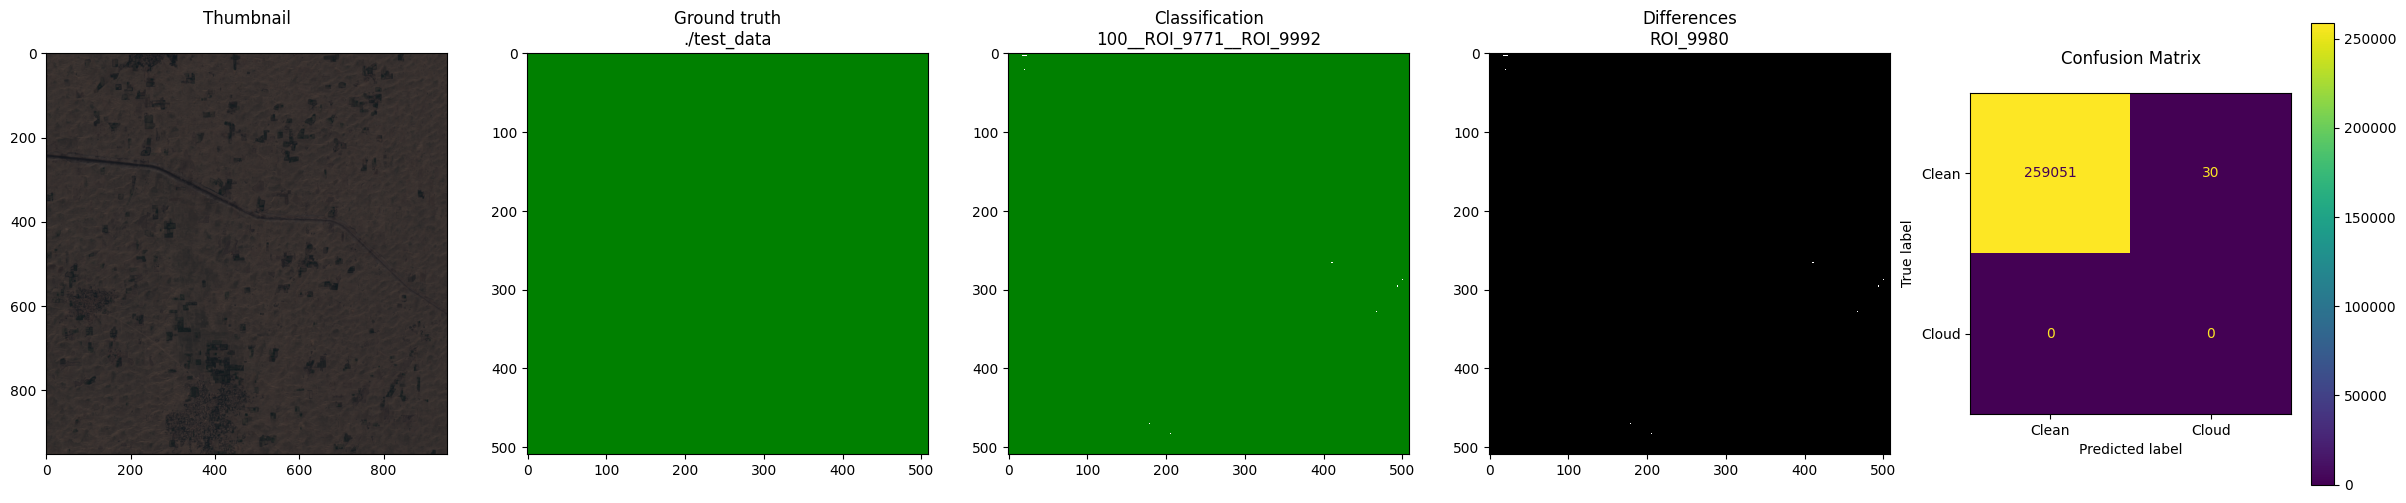

In [27]:
# Color map to show the manual_hq and predicted results    
cmap_clouds, norm_clouds  = matplotlib.colors.from_levels_and_colors(levels=[0.0,1.0,2.0,3.0],colors=['green','white','gray','brown'],extend='max')

# Color map to show the error (white means error)
cmap_diffs, norm_diffs  = matplotlib.colors.from_levels_and_colors(levels=[False,True],colors=['black','white'],extend='max')

test_paths = []
for dir in os.listdir(TEST_DATASET_DIRECTORY):
    for region in os.listdir(TEST_DATASET_DIRECTORY + '/' + dir):
        for image in os.listdir(TEST_DATASET_DIRECTORY + '/' + dir + '/' + region):
            test_paths.append([TEST_DATASET_DIRECTORY, dir, region, image])

np.random.shuffle(test_paths)
test_paths = test_paths[:10]

for path in test_paths:
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30, 6))
    axs[0].set_title('Thumbnail\n')
    axs[1].set_title('Ground truth\n' + path[0])
    axs[2].set_title('Classification\n' + path[1])
    axs[3].set_title('Differences\n' + path[2])
    axs[4].set_title('Confusion Matrix\n')

    # The rasters to use
    thumbnail = read_image_patch_file(os.path.join(*path, 'thumbnail.tif'))
    features, labels = read_image_data(os.path.join(*path))
    labels = labels > 0
    labels = labels.astype(int)
    manual_hq = labels.reshape(509,509)

    features = np.moveaxis(features, 0, 2)
    features = features.reshape(-1, features.shape[-1])
    # Adapt the following line to use your trained model, and any processing required
    pred_image = final_model.predict(features).reshape(509,509)
    error_matrix = pred_image != manual_hq

    # Show the rasters
    rasterio.plot.show(thumbnail, ax= axs[0] )    
    rasterio.plot.show(manual_hq, ax= axs[1], cmap=cmap_clouds, norm=norm_clouds, interpolation='none')    
    rasterio.plot.show(pred_image, ax= axs[2], cmap=cmap_clouds, norm=norm_clouds, interpolation='none')
    rasterio.plot.show(error_matrix, ax= axs[3], cmap=cmap_diffs, norm=norm_diffs, interpolation='none')

    # Construct the confusion matrix
    cm = confusion_matrix(manual_hq.reshape(509*509,), pred_image.reshape(509*509,), labels=[0, 1])
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Clean', 'Cloud']).plot(ax=axs[4])

    report = classification_report(manual_hq.reshape(509*509,), pred_image.reshape(509*509,), zero_division=0)
    print(report)
    plt.show()